## Imports

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import geopy.distance as dst
import numpy as np

### Read data

In [2]:
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\mit\Documents\wildfires\data\sit\2020 SIT DATA.accdb;')
conn = pyodbc.connect(conn_str)
incidents_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENTS', conn)
reports_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENT_209_REPORTS', conn)

lookup = pd.read_sql('select * from SIT209_HISTORY_SIT209_LOOKUP_CODES', conn)

inctyp_lookup = lookup[lookup['CODE_TYPE'] == 'INCIDENT_TYPE']
inctyp_lookup = dict(zip(inctyp_lookup['LUCODES_IDENTIFIER'], inctyp_lookup['CODE_NAME'])) 
incidents_df['INCTYP_IDENTIFIER'] = incidents_df['INCTYP_IDENTIFIER'].astype(str).map(inctyp_lookup)

resources_lookup = lookup[lookup['CODE_TYPE'] == 'RESOURCE_TYPE']
resources_lookup = dict(zip(resources_lookup['LUCODES_IDENTIFIER'], resources_lookup['CODE_NAME']))

resources_df = pd.read_sql('select * from SIT209_HISTORY_INCIDENT_209_RES_UTILIZATIONS', conn)
resources_df = resources_df[resources_df['INC209R_IDENTIFIER'].isin(reports_df['INC209R_IDENTIFIER'])]
resources_df['RESTYP_IDENTIFIER'] = resources_df['RESTYP_IDENTIFIER'].map(resources_lookup)

C:\Users\mit\anaconda3\envs\ihc\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\mit\anaconda3\envs\ihc\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\mit\anaconda3\envs\ihc\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\mit\anaconda3\envs\ihc\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) o

In [3]:
resources_df['RESTYP_IDENTIFIER'].isna().value_counts()

False    142653
Name: RESTYP_IDENTIFIER, dtype: int64

### Get GACCs, sanity check with plot

In [38]:
nwcg_units_df = pd.read_sql('select * from COMMONDATA_HISTORY_NWCG_UNITS', conn)
# dispatch_offices_df = pd.read_sql('select * from SIT209_HISTORY_DISPATCH_OFFICE_NWCG_UNITS', conn)

nwcg_to_gacc = dict(zip(nwcg_units_df['NWCG_IDENTIFIER'], nwcg_units_df['GACC']))
inc_id_to_gacc = dict(zip(incidents_df['INCIDENT_IDENTIFIER'], 
                          incidents_df['NWCG_PROT_UNIT_IDENTIFIER'].map(nwcg_to_gacc)))

aggs = {key:sum for key in ['RESOURCE_QUANTITY', 'RESOURCE_PERSONNEL']}
df = resources_df.groupby(['INC209R_IDENTIFIER', 'RESTYP_IDENTIFIER'], as_index=False).agg(aggs)

cols = ['INC_IDENTIFIER', 'INC209R_IDENTIFIER', 'REPORT_FROM_DATE','POO_LATITUDE', 
        'POO_LONGITUDE', 'CAUSE_IDENTIFIER']

clean_reports = reports_df[cols].copy()
clean_reports['GACC'] = clean_reports['INC_IDENTIFIER'].map(inc_id_to_gacc)

clean_reports = clean_reports.rename(columns={'INC_IDENTIFIER' : 'INCIDENT_IDENTIFIER'})

df = pd.merge(clean_reports, df, on='INC209R_IDENTIFIER', how='right')

wildfires = incidents_df[incidents_df['INCTYP_IDENTIFIER'] == 'Wildfire']['INCIDENT_IDENTIFIER']
df = df[df['INCIDENT_IDENTIFIER'].isin(wildfires)]

df['POO_LONGITUDE'] = df['POO_LONGITUDE'].astype(float)
df['POO_LATITUDE'] = df['POO_LATITUDE'].astype(float)

df_no_dup = df.drop_duplicates('INCIDENT_IDENTIFIER').copy()

C:\Users\mit\anaconda3\envs\ihc\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<AxesSubplot:xlabel='POO_LONGITUDE', ylabel='POO_LATITUDE'>

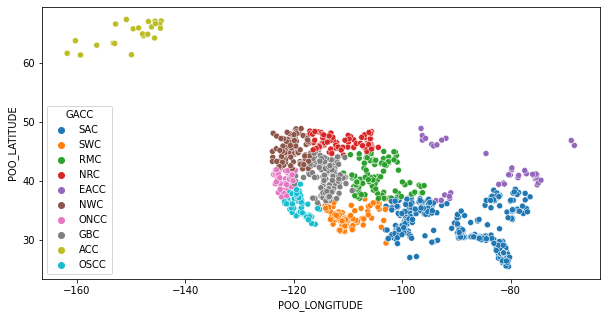

In [39]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.scatterplot(data=df_no_dup, x='POO_LONGITUDE', y='POO_LATITUDE', hue='GACC')

### Generate historical assignment data

#### Notes: 
- Type I crew different from "Interagency Hotshot Crew"
- Fake data with respect to rotations

In [59]:
sw = df[df['GACC'] == 'SWC'].copy()
sw_type_1 = sw[sw['RESTYP_IDENTIFIER'] == 'Crew, Type 1'].copy()
sw_type_1['RESOURCE_QUANTITY'] = sw_type_1['RESOURCE_QUANTITY'].astype(float)
sw_type_1['RESOURCE_PERSONNEL'] = sw_type_1['RESOURCE_PERSONNEL'].astype(float)
sw_type_1['ppl_per_crew'] = sw_type_1['RESOURCE_PERSONNEL']/sw_type_1['RESOURCE_QUANTITY']

sw_type_1 = sw_type_1[((sw_type_1['ppl_per_crew'] > 10) & (sw_type_1['ppl_per_crew'] < 30))].copy()

rot = df[~df['GACC'].isin(['SWC', 'SAC'])].copy()

np.random.seed(1)
sample = rot.sample(34).copy()
sample['RESOURCE_QUANTITY'] = [1] * 30 + [2] * 4

sw_type_1 = pd.concat([sw_type_1, sample])

sw_type_1['REPORT_FROM_DATE'] = sw_type_1['REPORT_FROM_DATE'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p"))
sw_type_1 = sw_type_1.sort_values('REPORT_FROM_DATE')
day_1 = sw_type_1['REPORT_FROM_DATE'].iloc[0].date()
sw_type_1['day'] = sw_type_1['REPORT_FROM_DATE'].apply(lambda x: (x.date() - day_1).days + 1)

sw_type_1['RESOURCE_QUANTITY'] = sw_type_1['RESOURCE_QUANTITY'].astype(float)
sw_type_1['RESOURCE_PERSONNEL'] = sw_type_1['RESOURCE_PERSONNEL'].astype(float)

sw_type_1 = sw_type_1.sort_values('RESOURCE_QUANTITY', ascending=False)
sw_type_1 = sw_type_1.drop_duplicates(['INCIDENT_IDENTIFIER', 'day'])

cols = ['INCIDENT_IDENTIFIER', 'POO_LATITUDE', 'POO_LONGITUDE', 'day', 'RESOURCE_QUANTITY', 'GACC']
new_cols = ['fire','lat', 'lon', 'day', 'demand', 'outside_gacc']
demands = sw_type_1[cols].rename(columns=dict(zip(cols, new_cols))).copy()
demands['demand'] = demands['demand'].astype(int)
demands['outside_gacc'] = demands['outside_gacc'] != 'SWC'
demands = demands.sort_values('day').reset_index(drop=True)

fire_ids = demands[['fire']].drop_duplicates().reset_index(drop=True).reset_index()
fire_ids = dict(zip(fire_ids['fire'], fire_ids['index'] + 1))

demands['fire_id'] = demands['fire'].map(fire_ids)

demands 

,fire,lat,lon,day,demand,outside_gacc,fire_id
0,11709158,33.296389,-111.251944,1,1,False,1
1,11702287,33.361640,-109.088600,19,1,False,2
2,11704780,36.919722,-106.889167,20,2,False,3
3,11704780,36.919850,-106.889200,21,2,False,3
4,11704780,36.919850,-106.889200,22,2,False,3
...,...,...,...,...,...,...,...
418,11970319,36.264230,-105.339600,186,1,False,102
419,11971929,33.271944,-110.983889,186,2,False,103
420,11979237,34.147222,-112.117778,187,1,False,104
421,11979237,34.147222,-112.117778,188,1,False,104


### Plot showing daily crew demands

<AxesSubplot:xlabel='day', ylabel='demand'>

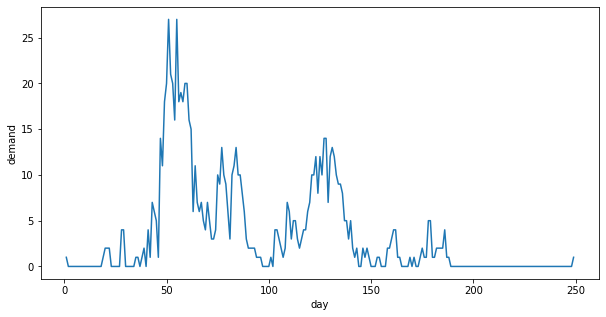

In [60]:
daily_demands = demands.groupby('day', as_index=False).agg({'demand' : sum})
fill = pd.DataFrame({'day' : range(1, daily_demands['day'].max() + 1), 'demand' : 0})
daily_demands = pd.concat([daily_demands, fill]).drop_duplicates('day').sort_values('day').reset_index()
sns.lineplot(data=daily_demands, x='day', y='demand')

### Generate some fire-to-fire distances (as the crow flies)

In [49]:
fires = demands.drop_duplicates('fire_id').sort_values('fire_id')
locs = fires[['lat', 'lon']].to_numpy()

n = locs.shape[0]

dists = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i < j:
            dists[i, j] = dst.distance(locs[i], locs[j]).miles
            dists[j, i] = dists[i, j]

<AxesSubplot:ylabel='Count'>

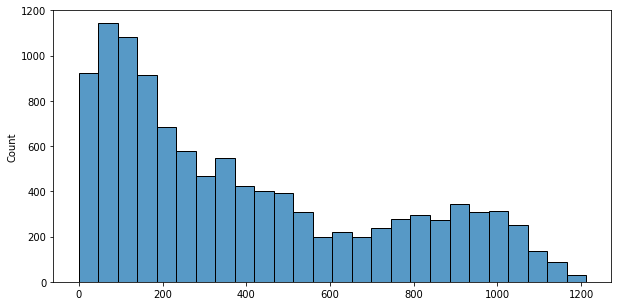

In [50]:
sns.histplot(data=np.ravel(dists))

### Invent some crew home base locations 

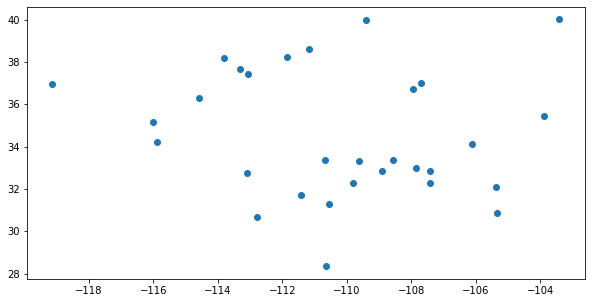

In [51]:
k=30

np.random.seed(123)
lats = demands['lat'].mean() + np.random.normal(size=k) * demands['lat'].std()
lons = demands['lon'].mean() + np.random.normal(size=k) * demands['lon'].std()

plt.scatter(lons, lats)

In [52]:
sim_bases = pd.DataFrame({'lat' : lats, 'lon' : lons})

base_locs = sim_bases.to_numpy()

m = base_locs.shape[0]
base_fire_dists = np.zeros((m, n))

for i in range(m):
    for j in range(n):
        base_fire_dists[i, j] = dst.distance(base_locs[i], locs[j]).miles
        
sns.histplot(data=np.ravel(base_fire_dists))

<AxesSubplot:ylabel='Count'>

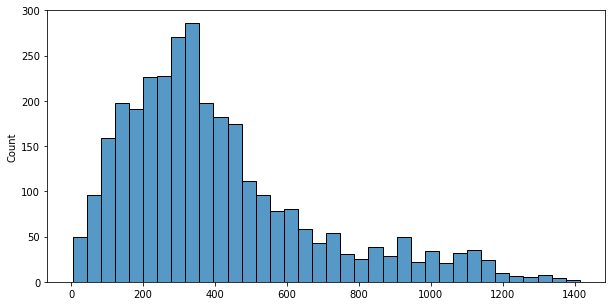

## Save

In [55]:
import os
os.mkdir('data')
os.mkdir('data/raw')
os.mkdir('data/tidied')
os.mkdir('data/processed')
np.savetxt('data/processed/base_fire_distances.csv', base_fire_dists, delimiter=',')
np.savetxt('data/processed/fire_distances.csv', dists, delimiter=',')
demands[['day', 'fire_id', 'demand', 'outside_gacc']].to_csv('data/processed/demands.csv', index=False)

### CHECK "GENERAL_FIRE_BEHAVIOR" FROM REPORTS AS A PREDICTOR
### CAUSE_IDENTIFIER INCIDENT_DF